In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
import os

SHIFT_START = 2000
CAPTURE     = 5000

# https://stackoverflow.com/questions/53308674/audio-frequencies-in-python
def read_wav(wav_file_name):
    sr, signal = wavfile.read(wav_file_name)
    return (sr, signal[SHIFT_START:(SHIFT_START + CAPTURE), 0]) # use the first channel (or take their average, alternatively)

def fetch_frequencies(wav_file_name):
    sr, y = read_wav(wav_file_name)
    return y

def show_frequency_spectrum(wav_file_name):
    sr, y = read_wav(wav_file_name)
    t = np.arange(len(y)) / float(sr)

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, y)
    plt.xlabel('t')
    plt.ylabel('y')
    axes = plt.gca()
    axes.set_ylim([-1e9, 1e9])

    plt.show()

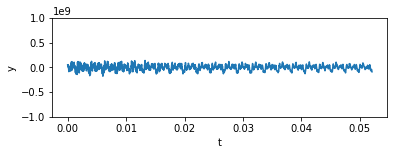

In [17]:
SAMPLES_DIR = 'samples'
TRAIN_DIR = 'train'
TEST_DIR = 'test'

show_frequency_spectrum(os.path.join(SAMPLES_DIR, 'A', TRAIN_DIR, '1_out_of_tune', 'splitted_chord009.wav'))

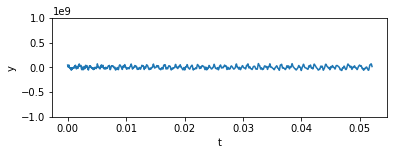

In [18]:
show_frequency_spectrum(os.path.join(SAMPLES_DIR, 'C', TRAIN_DIR, '1', 'splitted_chord007.wav'))

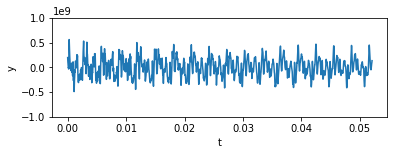

In [19]:
show_frequency_spectrum(os.path.join(SAMPLES_DIR, 'E', TRAIN_DIR, '1', 'splitted_chord007.wav'))

In [20]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(CAPTURE),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
import glob
import itertools

sound_names_index = {sound_name: idx for idx, sound_name in enumerate(os.listdir(SAMPLES_DIR))}
sound_names_index_reverted = {v: k for k, v in sound_names_index.items()}
print('Following sounds are going to be categorized')
print(list(sound_names_index.keys()))

Following sounds are going to be categorized
['A', 'C', 'E']


In [22]:
def parse_sound_name(path):
    sound_folders_depth = 1
    return os.path.normpath(path).split(os.path.sep)[sound_folders_depth]

def list_files(directory):
    files = glob.glob(os.path.join(SAMPLES_DIR, '*', directory, '*', '*.wav'))
    return {file: sound_names_index[parse_sound_name(file)] for file in files}

train_files = list_files(TRAIN_DIR)
test_files  = list_files(TEST_DIR)

In [23]:
import datetime

def files_to_tensors(files):
    return tf.convert_to_tensor([tf.convert_to_tensor(fetch_frequencies(file), np.int32) for file in files])

def labeled_files_to_tensors(labeled_files):
    x = files_to_tensors(labeled_files.keys())
    y = tf.convert_to_tensor(list(labeled_files.values()))
    return x, y

x, y           = labeled_files_to_tensors(train_files)
x_test, y_test = labeled_files_to_tensors(test_files)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

model.fit(x, y, validation_data=(x_test, y_test), callbacks=[tensorboard_callback], epochs=5)

Train on 93 samples, validate on 14 samples
Epoch 1/5
93/93 [==============================] - 1s 14ms/sample - loss: 1344607716.4731 - accuracy: 0.4624 - val_loss: 725678528.0000 - val_accuracy: 0.5714
Epoch 2/5
93/93 [==============================] - 1s 6ms/sample - loss: 726940362.3226 - accuracy: 0.7957 - val_loss: 534587648.0000 - val_accuracy: 0.6429
Epoch 3/5
93/93 [==============================] - 1s 6ms/sample - loss: 68289440.9462 - accuracy: 0.8710 - val_loss: 702230592.0000 - val_accuracy: 0.6429
Epoch 4/5
93/93 [==============================] - 1s 6ms/sample - loss: 134407964.2151 - accuracy: 0.8710 - val_loss: 600050368.0000 - val_accuracy: 0.6429
Epoch 5/5
93/93 [==============================] - 1s 6ms/sample - loss: 32865286.8817 - accuracy: 0.9355 - val_loss: 407887936.0000 - val_accuracy: 0.7857


In [25]:
# became kind of legacy after introducing validation_data param.
# But still used to get predictions for specific files.

def predict_files(files):
    files_data = files_to_tensors(files)
    for idx, prediction in enumerate(model.predict(files_data)):
        sound_name = sound_names_index_reverted[list(prediction).index(1)]
        print(f'{sound_name} - {files[idx]}')

predict_files(list(test_files.keys()))

A - samples/A/test/1_out_of_tune/splitted_chord001.wav
A - samples/A/test/1_out_of_tune/splitted_chord003.wav
A - samples/A/test/1_out_of_tune/splitted_chord002.wav
C - samples/C/test/2/splitted_chord001.wav
C - samples/C/test/2/splitted_chord003.wav
C - samples/C/test/2/splitted_chord002.wav
E - samples/C/test/2/splitted_chord004.wav
C - samples/C/test/1/splitted_chord001.wav
A - samples/C/test/1/splitted_chord003.wav
C - samples/C/test/1/splitted_chord002.wav
C - samples/E/test/1/splitted_chord001.wav
E - samples/E/test/1/splitted_chord005.wav
E - samples/E/test/1/splitted_chord002.wav
E - samples/E/test/1/splitted_chord004.wav


In [24]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7247), started 0:34:32 ago. (Use '!kill 7247' to kill it.)